In [1]:
import random
import copy
import math
import numpy as np
import csv
from numpy import nan
import matplotlib.pyplot as plt
import pandas as pd



# Functions

## Global Variables

In [2]:
graph = {}
states = {}
optimal_states = {}
Enable_Visulization = False
ENABLE_WRITE = False
pred_probs = {}
prey_probs = {}

## Create Graph

In [3]:
def create_graph(N):
  graph = {}

  #add forward edges
  for i in range(1,N):
    graph[i]=[(i+1)]
  graph[N]=[1]

  #add backward edges
  for i in range(2,N+1):
    graph[i].append(i-1)
  graph[1].append(N)

  temp = [i for i in range(1,N+1)]
  #add random edges
  while(len(temp)>0):
    u = random.choice(temp)
    possible_v = [i%N if i%N !=0 else N for i in range(u+1+1,u+5+1)] #+5 nodes excludes the neighbour to avoid duplicate edge
    possible_v += [i%N if i%N !=0 else N for i in range(u-5,u-1)]    #-5 nodes excludes the neighbour to avoid duplicate edge
    possible_v = [i for i in possible_v if i in temp]
    if(len(possible_v)>0):
      v = random.choice(possible_v)
      graph[u].append(v)
      graph[v].append(u)
      temp.remove(v)
    temp.remove(u)

  return(graph)


## Shortest Path Calculation

In [4]:
def BFS(src, dest, pred, dist):

  queue = []
  visited = [False for i in range(len(graph)+1)]

  #initializing dist and predecessor array
  for i in range(len(graph)+1):
    dist[i] = 1000000
    pred[i] = -1

  visited[src] = True
  dist[src] = 0
  queue.append(src)

  # BFS
  while (len(queue) != 0):
    u = queue[0]
    queue.pop(0)
    for i in range(len(graph[u])):
      if (visited[graph[u][i]] == False):
        visited[graph[u][i]] = True
        dist[graph[u][i]] = dist[u] + 1
        pred[graph[u][i]] = u
        queue.append(graph[u][i])

        # stop when destination is found
        if (graph[u][i] == dest):
          return True

  return False


def calculate_shortest_distance(src, dest):

  if src==dest:
    return 0, []

  pred=[0 for i in range(len(graph)+1)]
  dist=[0 for i in range(len(graph)+1)]

  if (BFS(src, dest, pred, dist) == False):
    print("BFS returned False:\n graph, src, dest, pred, dist",graph, src, dest, pred, dist)
    return False

  # storing path 
  path = []
  crawl = dest
  path.append(crawl)

  while (pred[crawl] != -1):
    path.append(pred[crawl])
    crawl = pred[crawl]

  min_dist = dist[dest]
  path.reverse()

  return min_dist, path 

## Initialise the Utility


In [5]:
def initialize_utilities(graph):

  # global states
  states = {}
  # learnable = set()

  for agent in range(1,len(graph)+1):
    for prey in range(1,len(graph)+1):
      for pred in range(1,len(graph)+1):

        # pred caught agent
        if agent==pred:
          states[(agent,prey,pred)] = math.inf
        
        # agent caught prey
        elif agent==prey and pred!= prey:
          states[(agent,prey,pred)] = 0

        #prey is in neighbour of agent
        elif prey in graph[agent] and agent!=pred:
          states[(agent,prey,pred)] = 1
        
        # pred is in distance 1 from agent or agent, prey, pred are in the same pos
        elif pred in graph[agent] or (agent==prey and pred== prey):
          states[(agent,prey,pred)] = math.inf

        # # pred is in distance 2 from agent
        # elif (any(check in graph[pred] for check in graph[agent])):
        #   if(agent==6 and prey==1 and pred==4):
        #     print(any(check in graph[pred] for check in graph[agent]))
        #     print(graph[pred],graph[agent])
        #   states[(agent,prey,pred)] = math.inf
        
        # we don't know the state value, we are initilializing it as the shortest distance between angent and prey
        else:
          min_dist, path = calculate_shortest_distance(agent, prey)
          states[(agent,prey,pred)] = min_dist
          # learnable.add((agent,prey,pred))

  return states

## Plot Graph

In [6]:
def plot(x,y,set_xlim,set_ylim,xlabel,ylabel,title,colour):
  plt.plot(y, colour)
  if set_xlim[0]: plt.xlim(set_xlim[1])
  if set_ylim[0]: plt.ylim(set_ylim[1])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

## Update Utilities

In [7]:
def compute_pred_prob(pred_pos,agent_pos):

  possible_pred_moves = graph[pred_pos]
  num_of_pred_moves = len(graph[pred_pos])

  #Initial pred probability
  pred_probs = {(agent_pos,pred_pos,i) : 0.4*(1/num_of_pred_moves) for i in graph[pred_pos] }
  dist = {}
  closest_neighbours = []
  for neighbor in graph[pred_pos]:
    dist_l, path = calculate_shortest_distance(neighbor,agent_pos)
    dist[(agent_pos,pred_pos,neighbor)]=dist_l
  min_dist = min(dist.values())
  closest_neighbours += [i for i in dist if dist[i]==min_dist]
  # Update pred Probabilities
  for node in closest_neighbours:
      pred_probs[node] += 0.6*(1/len(closest_neighbours)) 
  return pred_probs

def compute_prey_prob(prey_pos):
  possible_prey_moves = graph[prey_pos]+[prey_pos]
  prey_probs = {(prey_pos,node):1/len(possible_prey_moves) for node in possible_prey_moves}
  return prey_probs

def update_utilities(states,beta):

  iterations = 0

  prey_probs = {}
  pred_probs = {}

  error_l = []

  for prey_pos in range(1,len(graph)+1):
    prey_probs.update(compute_prey_prob(prey_pos))

  for agent_pos in range(1,len(graph)+1):
    for pred_pos in range(1,len(graph)+1):
      pred_probs.update(compute_pred_prob(pred_pos,agent_pos))

  u_k = copy.deepcopy(states)
  u_k1 = copy.deepcopy(states)

  while(True):
    u_k = copy.deepcopy(u_k1)
    u_k1 = {}
    error = float('-inf')

    for state in u_k:

      agent_pos = state[0]
      possible_agent_moves = graph[agent_pos] + [agent_pos]
      prey_pos = state[1]
      possible_prey_moves = graph[prey_pos] + [prey_pos]
      pred_pos = state[2]
      possible_pred_moves = graph[pred_pos]

      if agent_pos==pred_pos or prey_pos==agent_pos or pred_pos in possible_agent_moves or prey_pos in possible_agent_moves:# or (any(check in graph[pred_pos] for check in graph[agent_pos])):
        u_k1[state] = u_k[state]

      else:
        p_sum = 0
        p_min = math.inf

        for agent_post in possible_agent_moves:
          p_sum=0
          for prey_post in possible_prey_moves:
            for pred_post in possible_pred_moves:
              p_sum += prey_probs[(prey_pos,prey_post)] * pred_probs[(agent_post,pred_pos,pred_post)] * u_k[agent_post,prey_post,pred_post]
          p_min=min(p_min,p_sum)
        u_k1[state] = (1 + (beta*p_min))
        error = max(error, abs(u_k1[state] - u_k[state]))
     
    iterations += 1

    # print("Iteration ",iterations," => Error:",error)
    error_l.append(error)

    if(error<=0.001):
      break
  # print("Number of Iterations taken to converge:",iterations)
  plot(iterations,error_l,[False,[]],[False,[]],"Time","Error","Error v/s Time Full Plot","r")
  return u_k1


## Initialize Agent,Prey and Pred positions

In [8]:
def initilise_prey_pred_agent():
  nodes = [i for i in range(1,len(graph)+1)]
  current_agent_pos = random.choice(nodes)
  nodes.remove(current_agent_pos)
  current_prey_pos = random.choice(nodes)
  current_pred_pos = random.choice(nodes)
  return current_agent_pos,current_prey_pos,current_pred_pos

## Modeling Prey and Predator

In [9]:
def move_prey(graph, current_prey_pos):
  temp = graph[current_prey_pos].copy()
  temp.append(current_prey_pos)
  t = random.randint(0,len(temp)-1)
  next_move = temp[t]
  return next_move

In [10]:
def move_distracted_predator(graph, current_pred_pos, current_agent_pos):
  c = random.uniform(0, 1)
  temp = graph[current_pred_pos] 

  if (c<=0.6):
    dist = []
    
    for i in temp:
      if(calculate_shortest_distance(i, current_agent_pos)):
        x, y = calculate_shortest_distance(i, current_agent_pos)
        dist.append(x)
      else:
        dist.append(100000)
    shortest_distance = min(dist)
    possible_moves = []
    for i in range(len(temp)):
      if dist[i]==shortest_distance:
        possible_moves.append(temp[i])
    
    if len(possible_moves)>1:
      return possible_moves[random.randint(0,len(possible_moves)-1)]
    return possible_moves[0]
  else:
    return temp[random.randint(0,len(temp)-1)]

## Agent U

In [11]:
def move_agent_U(graph, current_agent_pos, current_prey_pos, current_pred_pos,states):
  agent_neighbours = graph[current_agent_pos] + [current_agent_pos]
  possible_states = []
  utility_vals = []
  tt = {}
  for i in agent_neighbours:
    state = (i,current_prey_pos, current_pred_pos)
    uv = states[state]
    possible_states.append(state)
    utility_vals.append(uv)
    tt[state[0]] = uv
  if Enable_Visulization:print(("Anget's turn to move:\nAvilable agent moves with respective utilities: {}").format(tt))
  # temp_tt = {i:tt[i] for i in tt if math.inf not in graph[i]}
  # for i in tt:
  #   print((i,graph[i]))
  # print((i,temp_tt)
  # if len(temp_tt)>0:
  #   min_uv = min(temp_tt.values())
  #   possible_states2 = []
  #   for i in temp_tt:
  #     if temp_tt[i]==min_uv:
  #       possible_states2.append(i)
  #   t = random.randint(0,len(possible_states2)-1)
  # else:
  min_uv = min(utility_vals)
  possible_states2 = []
  for i in range(0,len(utility_vals)):
    if utility_vals[i]==min_uv:
      possible_states2.append(possible_states[i])
  t = random.randint(0,len(possible_states2)-1)

  return possible_states2[t][0]
  


def agent_U(states,current_agent_pos ,current_prey_pos ,current_pred_pos):
  time_step = 0
  ini_prey_pos = 0

  while (True):
    if Enable_Visulization:print(("Round {} => Current Agent, Prey and Pred positions are: {} , {} , {}").format(time_step,current_agent_pos ,current_prey_pos ,current_pred_pos))
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos])
      break
    elif (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_step])
      break
    elif (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_step])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    current_agent_pos = move_agent_U(graph, current_agent_pos, current_prey_pos, current_pred_pos,states)
    # if Enable_Visulization:print(("Agent choses the node with minimum Utility by breaking ties at random. Agent moves to : {}").format(current_agent_pos))
    # if Enable_Visulization:print(("Agent moves to : {}").format(current_agent_pos))
    if (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_step])
    if (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_step])

    if ini_prey_pos >= len(prey_pos_list):
      current_prey_pos = move_prey(graph, current_prey_pos)
      prey_pos_list.append(current_prey_pos) 
      ini_prey_pos += 1
    else:
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    
    # if Enable_Visulization:print(("Prey moves to : {}").format(current_prey_pos))
    if (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_step])

    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)
    # if Enable_Visulization:print(("Predator moves to : {}").format(current_pred_pos))

    if Enable_Visulization:print(("Agent moves to : {} , Prey moves to : {} , Predator moves to : {}").format(current_agent_pos,current_prey_pos,current_pred_pos))

    time_step += 1

    # print("count = ",count," val = ",[current_agent_pos, current_prey_pos, current_pred_pos])


## Belief Updates

In [12]:
def update_belief_survey(beliefs, t, state, graph, node_degree, pos_where_prey_not_there):
  new_beliefs = [0]*len(beliefs)
  if state == True: # found the prey
    new_beliefs[t] = 1
    for i in range(len(beliefs)):
      if i!=t:
        new_beliefs[i]=0

  if state == False: # did not find the prey
    # P(prey in nodes| survey failed to find prey at node t) = P(prey in node)* 1 / P(1 - P(prey in t))

    for i in range(1,len(beliefs)):
      if i not in pos_where_prey_not_there :
        new_belief = beliefs[i] * 1/(1-beliefs[t])
        new_beliefs[i] = new_belief
    
    new_beliefs[t] = 0

  return new_beliefs
  


def update_belief_move(beliefs, graph, node_degree):
  updated_beliefs = [0]*len(beliefs)
  # P(prey at node i at t=1) = summation ( P(prey at neighbour)* P(prey moving to node i from neighbour i))
  for i in range(1,len(beliefs)):
    neighbours = graph[i]+[i]
    new_belief = 0
    for j in neighbours:
      alpha = 1/(node_degree[j]+1)
      #print('denominator:',denominator)
      new_belief += (beliefs[j]*alpha)
    updated_beliefs[i] = new_belief

  return updated_beliefs

## Agent U partial

In [13]:
def utility_update_partial_env(agent_pos,prey_beliefs,pred_pos):
  sum = 0
  for i in range(1,len(prey_beliefs)):
    if ((agent_pos==pred_pos) or pred_pos in graph[agent_pos]):
      return math.inf
    sum += prey_beliefs[i] * optimal_states[(agent_pos,i,pred_pos)]
  return sum


def move_agent_U_partial(graph, current_agent_pos, prey_beliefs, current_pred_pos,states):
  agent_neighbours = graph[current_agent_pos] + [current_agent_pos]
  utility_vals = {}
  for neighbour in agent_neighbours:
    uv= utility_update_partial_env(neighbour,prey_beliefs,current_pred_pos)
    if(str(uv)!="nan"):
      utility_vals[neighbour] = uv
  min_uv = min(utility_vals.values())
  best_move = [i for i in utility_vals if utility_vals[i]==min_uv]
  if(len(best_move)<=0):
    print("hh")
  return random.choice(best_move)
  

In [101]:
def agent_U_partial(current_agent_pos , current_prey_pos , current_pred_pos , states, writer):

  timesteps = 0
  ini_prey_pos = 0
  correctly_identified_prey_pos = 0
  # initialize prey beliefs
  beliefs = [1/49]*(len(graph)+1)
  beliefs[0] = 0
  beliefs[current_agent_pos] = 0
  pos_where_prey_not_there = []
  pos_where_prey_not_there.append(current_agent_pos)



  while (True):
    store_row = [current_agent_pos,current_pred_pos,len(graph[current_agent_pos]),len(graph[current_pred_pos]),calculate_shortest_distance(current_agent_pos,current_pred_pos)[0]]
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return ("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    elif (current_agent_pos == current_prey_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    elif (current_agent_pos == current_pred_pos):
      return ("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    

  
    # agent 3 surveys nodes and returns the next move of the agent
    
    # find node with max belief, cut ties at random
    max_belief = max(beliefs)

    nodes_with_max_belief = [i for i in range(1,len(beliefs)) if beliefs[i]==max_belief]
    # surveyed_node = nodes_with_max_belief[random.randint(0,len(nodes_with_max_belief)-1)]
    if(len(nodes_with_max_belief)<=0):
      print("h",beliefs)
      break
    surveyed_node = random.choice(nodes_with_max_belief)

    store_row.append(surveyed_node)

    temp_store_row = copy.deepcopy(store_row)

    store_row += beliefs

    # write a row to the csv file
    if ENABLE_WRITE: writer.writerow(store_row)

    # store_row.pop()
    store_row = copy.deepcopy(temp_store_row)

    # survey the node
    if surveyed_node == current_prey_pos:
      state = True
      correctly_identified_prey_pos += 1
    else:
      state = False
      pos_where_prey_not_there.append(surveyed_node)  
    
    # update beliefs
    beliefs = update_belief_survey(beliefs, surveyed_node, state, graph,node_degree,pos_where_prey_not_there)
    store_row += beliefs
    # store_row.append(beliefs)

    # write a row to the csv file
    if ENABLE_WRITE: writer.writerow(store_row)
    # store_row.pop()
    store_row = copy.deepcopy(temp_store_row)
    
    # choose node with max probability as the prey pos and moving agent towards it
    max_belief = max(beliefs)
    nodes_with_max_belief = []
    for i in range(len(beliefs)):
      if beliefs[i]==max_belief:
        nodes_with_max_belief.append(i)
    #print(max_belief, nodes_with_max_belief)
    # t = random.randint(0,len(nodes_with_max_belief)-1)
    if(len(nodes_with_max_belief)<=0):
      print("h2",max_belief)
      break
    
    prey_pos = random.choice(nodes_with_max_belief)
    agent_next_pos = move_agent_U_partial(graph, current_agent_pos, beliefs, current_pred_pos,states)
    


    # move the agent to next pos
    current_agent_pos = agent_next_pos
    timesteps += 1

    # check if pred in agent pos
    if current_agent_pos == current_pred_pos: # pred kills agent
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    # if (timesteps > t_hangs):
    #   return("agent timesteps!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])


    # update the beliefs after agent moves
    if current_agent_pos == current_prey_pos: # prey found
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    else: # prey not found
      state = False
      pos_where_prey_not_there.append(current_agent_pos)
      beliefs = update_belief_survey(beliefs, current_agent_pos, state, graph,node_degree,pos_where_prey_not_there)
      # store_row.append(beliefs)
      store_row += beliefs

      # write a row to the csv file
      if ENABLE_WRITE: writer.writerow(store_row)
      # store_row.pop()
      store_row = copy.deepcopy(temp_store_row)

    #current_agent_pos, beliefs, state_p, surveyed_node = move_agent3(graph, current_agent_pos, current_prey_pos,beliefs,node_degree)

    #print("update the beliefs after agent moves",sum(beliefs))
    #print(beliefs)
    

    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) 
    pos_where_prey_not_there = []

    # current_prey_pos = move_prey(graph, current_prey_pos)


    # update beliefs after prey moves
    if (current_prey_pos==current_agent_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    else:
      beliefs = update_belief_move(beliefs, graph, node_degree)

    #print("update beliefs after prey moves:",sum(beliefs))
    #print(beliefs)

    # predator moves
    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)





## Visulization for max finite utility

In [15]:
def visulization_max_finite_utility(states):
  global Enable_Visulization
  Enable_Visulization = True
  max_U = 0
  state_max_U = set()
  for i in optimal_states:
    if(optimal_states[i]!=math.inf and optimal_states[i]>max_U):
      max_U = optimal_states[i]
      state_max_U = i
  print(("Max finite Utility is {} and the state is {}").format(max_U,state_max_U))
  print("Let's simulate the game")
  print(("Initialization: Agent Position = {} , Prey Position = {} , Predator Position = {}").format(state_max_U[0],state_max_U[1],state_max_U[2]))
  status, vals = agent_U(states,state_max_U[0],state_max_U[1],state_max_U[2])
  print(status)

  Enable_Visulization = False



## Project 2 Agents

### Agent 1

In [16]:
def move_agent1(graph, curr_agent_pos, prey_pos, pred_pos):
  dist_c_prey, x = calculate_shortest_distance(curr_agent_pos, prey_pos)
  dist_c_pred, x = calculate_shortest_distance(curr_agent_pos, pred_pos)
  dist_from_prey = []
  dist_from_pred = []
  global p1,p2 
  for i in range(len(graph[curr_agent_pos])):
    t1, t2 = calculate_shortest_distance(graph[curr_agent_pos][i], prey_pos)
    dist_from_prey.append(t1)
    t1, t2 = calculate_shortest_distance(graph[curr_agent_pos][i], pred_pos)
    dist_from_pred.append(t1)
  p1,p2 = random.uniform(30*30, 63),random.uniform(65.0, 67.5)

  #Neighbors that are closer to the Prey and farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000

  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]<dist_c_prey and dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[len(d_n)-1][1]

  #Neighbors that are closer to the Prey and not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]<dist_c_prey and dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[0][1]

  #Neighbors that are not farther from the Prey and farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]==dist_c_prey and dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[len(d_n)-1][1]

  #Neighbors that are not farther from the Prey and not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]==dist_c_prey and dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]

  #Neighbors that are farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]
  
  #Neighbors that are not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]

  #Sit still and pray.
  return curr_agent_pos


In [17]:
def agent1( current_agent_pos , current_prey_pos , current_pred_pos):
  time_steps = 0
  ini_prey_pos = 0

  while (True):
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    current_agent_pos = move_agent1(graph, current_agent_pos, current_prey_pos, current_pred_pos)
    if (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
    elif (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
    
    current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) #add the prey moves to list

    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) 

    if (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])

    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)
    time_steps += 1



### Agent 2

In [18]:
def move_agent2(graph, curr_agent_pos, prey_pos, pred_pos):
  dist_c_prey, dist_c_prey_path = calculate_shortest_distance(curr_agent_pos, prey_pos)
  dist_c_pred, dist_c_pred_path = calculate_shortest_distance(curr_agent_pos, pred_pos)
  dist_from_prey = []
  dist_from_pred = []
  dist_from_prey_path = []
  dist_from_pred_path = []
  temp_prey_pred = []
  for i in range(len(graph[curr_agent_pos])):
    t1, t2 = calculate_shortest_distance(graph[curr_agent_pos][i], prey_pos)
    dist_from_prey.append(t1)
    dist_from_prey_path.append(t2)
    t1, t2 = calculate_shortest_distance(graph[curr_agent_pos][i], pred_pos)
    dist_from_pred.append(t1)
    dist_from_pred_path.append(t2)
    temp_prey_pred.append((dist_from_prey[-1],dist_from_pred[-1]))


  temp_zip = list(zip(temp_prey_pred,graph[curr_agent_pos]))

  min_prey = min(dist_from_prey)
  max_pred = max(dist_from_pred)


  #Neighbors that are closer to the Prey and farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000

  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]<dist_c_prey and dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])

  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[len(d_n)-1][1]

  #if the pred is less than 5 steps away from agent and the distance to prey is greater than distance to pred and is the dist to pred is greater than the current nodes dist to pred then move to that node.
  if(dist_c_prey > dist_c_pred and dist_c_pred < 3  and max_pred > dist_c_pred):
    node = [x[1] for x in temp_zip if x[0][1]==max_pred]
    node = node[random.randint(0,len(node)-1)]
    return(node)

  #Neighbors that are closer to the Prey and not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]<dist_c_prey and dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[0][1]

  #Neighbors that are not farther from the Prey and farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]==dist_c_prey and dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    d_n.sort()
    d_n = [x for x in d_n if x[0][0]==min_prey]
    return d_n[len(d_n)-1][1]

  #Neighbors that are not farther from the Prey and not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_prey[i]==dist_c_prey and dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]

  #Neighbors that are farther from the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_pred[i]>dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]
  
  #Neighbors that are not closer to the Predator.
  temp_node = []
  temp_prey_pred = []
  min_prey = 10000
  for i in range(len(graph[curr_agent_pos])):
    if dist_from_pred[i]==dist_c_pred:
      temp_node.append(graph[curr_agent_pos][i])
      temp_prey_pred.append((dist_from_prey[i],dist_from_pred[i]))
      min_prey = min(min_prey,dist_from_prey[i])
  if len(temp_node)>0:
    d_n = list(zip(temp_prey_pred,temp_node))
    return d_n[random.randint(0,len(d_n)-1)][1]

  #Sit still and pray.
  return curr_agent_pos
    


In [19]:
def agent2( current_agent_pos , current_prey_pos , current_pred_pos):
  time_steps = 0
  ini_prey_pos = 0

  while (True):
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    current_agent_pos = move_agent2(graph, current_agent_pos, current_prey_pos, current_pred_pos)
    if (current_agent_pos == current_pred_pos):
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
    elif (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
    
    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)

    prey_pos_list.append(current_prey_pos) #add the prey moves to list
    if (current_agent_pos == current_prey_pos):
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])

    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)
    time_steps += 1



### Agnet 3

In [20]:
def agent3(current_agent_pos , current_prey_pos , current_pred_pos):

  time_steps = 0
  ini_prey_pos = 0
  correctly_identified_prey_pos = 0
  # initialize prey beliefs
  beliefs = [1/49]*(len(graph)+1)
  beliefs[0] = 0
  beliefs[current_agent_pos] = 0
  pos_where_prey_not_there = []
  pos_where_prey_not_there.append(current_agent_pos)

  while (True):
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return ("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_prey_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_pred_pos):
      return ("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    
    #print(sum(beliefs))
  
    # agent 3 surveys nodes and returns the next move of the agent
    
    # find node with max belief, cut ties at random
    max_belief = max(beliefs)
    nodes_with_max_belief = [i for i in range(1,len(beliefs)) if beliefs[i]==max_belief]
    surveyed_node = nodes_with_max_belief[random.randint(0,len(nodes_with_max_belief)-1)]

    # survey the node
    if surveyed_node == current_prey_pos:
      state = True
      correctly_identified_prey_pos += 1
    else:
      state = False
      pos_where_prey_not_there.append(surveyed_node)  
    
    # update beliefs
    beliefs = update_belief_survey(beliefs, surveyed_node, state, graph,node_degree,pos_where_prey_not_there)
    
    # choose node with max probability as the prey pos and moving agent towards it
    max_belief = max(beliefs)
    nodes_with_max_belief = []
    for i in range(len(beliefs)):
      if beliefs[i]==max_belief:
        nodes_with_max_belief.append(i)
    #print(max_belief, nodes_with_max_belief)
    t = random.randint(0,len(nodes_with_max_belief)-1)
    
    prey_pos = nodes_with_max_belief[t]
    agent_next_pos = move_agent1(graph, current_agent_pos, prey_pos, current_pred_pos)


    # move the agent to next pos
    current_agent_pos = agent_next_pos
    time_steps += 1

    # check if pred in agent pos
    if current_agent_pos == current_pred_pos: # pred kills agent
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    


    # update the beliefs after agent moves
    if current_agent_pos == current_prey_pos: # prey found
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    else: # prey not found
      state = False
      pos_where_prey_not_there.append(current_agent_pos)
      beliefs = update_belief_survey(beliefs, current_agent_pos, state, graph,node_degree,pos_where_prey_not_there)

    #current_agent_pos, beliefs, state_p, surveyed_node = move_agent3(graph, current_agent_pos, current_prey_pos,beliefs,node_degree)

    #print("update the beliefs after agent moves",sum(beliefs))
    #print(beliefs)
    

    # prey moves
    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) 
    pos_where_prey_not_there = []


    # update beliefs after prey moves
    if (current_prey_pos==current_agent_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    else:
      beliefs = update_belief_move(beliefs, graph, node_degree)

    #print("update beliefs after prey moves:",sum(beliefs))
    #print(beliefs)

    # predator moves
    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)




### Agent 4

In [21]:
def agent4(current_agent_pos , current_prey_pos , current_pred_pos):

  time_steps = 0
  ini_prey_pos = 0
  correctly_identified_prey_pos = 1
  # initialize prey beliefs
  beliefs = [1/49]*(len(graph)+1)
  beliefs[0] = 0
  beliefs[current_agent_pos] = 0
  pos_where_prey_not_there = []
  pos_where_prey_not_there.append(current_agent_pos)

  while (True):
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return ("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_prey_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    elif (current_agent_pos == current_pred_pos):
      return ("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    
    #print(sum(beliefs))
  
    # agent 3 surveys nodes and returns the next move of the agent
    
    # find node with max belief, cut ties at random
    max_belief = max(beliefs)
    nodes_with_max_belief = [i for i in range(1,len(beliefs)) if beliefs[i]==max_belief]
    surveyed_node = nodes_with_max_belief[random.randint(0,len(nodes_with_max_belief)-1)]

    # survey the node
    if surveyed_node == current_prey_pos:
      state = True
      correctly_identified_prey_pos += 1
    else:
      state = False
      pos_where_prey_not_there.append(surveyed_node)  
    
    # update beliefs
    beliefs = update_belief_survey(beliefs, surveyed_node, state, graph,node_degree,pos_where_prey_not_there)
    
    # choose node with max probability as the prey pos and moving agent towards it
    max_belief = max(beliefs)
    nodes_with_max_belief = []
    for i in range(len(beliefs)):
      if beliefs[i]==max_belief:
        nodes_with_max_belief.append(i)
    #print(max_belief, nodes_with_max_belief)
    t = random.randint(0,len(nodes_with_max_belief)-1)
    
    prey_pos = nodes_with_max_belief[t]
    agent_next_pos = move_agent2(graph, current_agent_pos, prey_pos, current_pred_pos)


    # move the agent to next pos
    current_agent_pos = agent_next_pos
    time_steps += 1

    # check if pred in agent pos
    if current_agent_pos == current_pred_pos: # pred kills agent
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break


    # update the beliefs after agent moves
    if current_agent_pos == current_prey_pos: # prey found
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    else: # prey not found
      state = False
      pos_where_prey_not_there.append(current_agent_pos)
      beliefs = update_belief_survey(beliefs, current_agent_pos, state, graph,node_degree,pos_where_prey_not_there)

    #current_agent_pos, beliefs, state_p, surveyed_node = move_agent3(graph, current_agent_pos, current_prey_pos,beliefs,node_degree)

    #print("update the beliefs after agent moves",sum(beliefs))
    #print(beliefs)
    

    # prey moves
    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) 
    pos_where_prey_not_there = []


    # update beliefs after prey moves
    if (current_prey_pos==current_agent_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,time_steps])
      break
    else:
      beliefs = update_belief_move(beliefs, graph, node_degree)

    #print("update beliefs after prey moves:",sum(beliefs))
    #print(beliefs)

    # predator moves
    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)

## Compare Functions

### Agent1 v/s Agent 2 v/s Agent U* 

In [22]:
def compare_agent1_agentU(optimal_states):
  global prey_pos_list
  states = copy.deepcopy(optimal_states)
  winsU, winsA1, winsA2 = [0,0,0]
  time_stepU,time_stepA1,time_stepA2 =[[],[],[]]
  simulations = 3000
  for i in range(simulations):

    current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()

    statusA1, valsA1 = agent1(current_agent_pos ,current_prey_pos ,current_pred_pos)
    if statusA1 == "agent wins!":
      winsA1 += 1

    statusA2, valsA2 = agent2(current_agent_pos ,current_prey_pos ,current_pred_pos)
    if statusA2 == "agent wins!":
      winsA2 += 1

    statusU, valsU = agent_U(states,current_agent_pos ,current_prey_pos ,current_pred_pos)
    if statusU == "agent wins!":
      winsU += 1
    
    if(statusA1 == "agent wins!" and statusU == "agent wins!" and statusA2 == "agent wins!"):
      time_stepU.append(valsU[-1])
      time_stepA1.append(valsA1[-1])
      time_stepA2.append(valsA2[-1])

    prey_pos_list = []

  print(("Success Rate for Agent 1: {}    and     Success Rate for Agent U: {}    and     Success Rate for Agent 2: {}\n\n").format((winsA1/simulations)*100,(winsU/simulations)*100,(winsA2/simulations)*100))
  print(("Avg Steps for Agent 1: {}    and     Avg Steps for Agent U: {}    and     Avg Steps for Agent 2: {}\n\n").format(sum(time_stepA1)/len(time_stepA1),sum(time_stepU)/len(time_stepU),sum(time_stepA2)/len(time_stepA2)))
  # plot(iterations,error_l,[False,[]],[False,[]],"Time","Error","Error v/s Time Full Plot","r")
  # plt.plot(time_stepU[:10], label = "Agent U")
  # plt.plot(time_stepA2[:10], label = "Agent 2")
  # plt.plot(time_stepA1[:10], label = "Agent 1")
  # plt.xlabel("Time")
  # plt.ylabel("Num of steps")
  # plt.title("AgentU/Agent2/Agent1: Time v/s Num of steps taken to catch Prey")
  # plt.legend()
  # plt.show()
  # print(time_stepU)
  # print(time_stepA1)
  # print(time_stepA2)
  states =  copy.deepcopy(temp_states)

### Agent3 v/s Agent4 v/s Agent U Partial

In [99]:
def compare_agent3_agent4_agentUPartial(optimal_states):
  global prey_pos_list
  states = copy.deepcopy(optimal_states)
  winsUP, winsA3, winsA4 = [0,0,0]
  time_stepUP,time_stepA3,time_stepA4 =[[],[],[]]
  ENABLE_WRITE = False
  # open the file in the write mode
  f = open('csv_file', 'w')
  # create the csv writer
  writer = csv.writer(f)
  simulations = 100
  for i in range(simulations):

    current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()
    statusA3, valsA3 = agent3(current_agent_pos ,current_prey_pos ,current_pred_pos)
    if statusA3 == "agent wins!":
      winsA3 += 1
    statusA4, valsA4 = agent4(current_agent_pos ,current_prey_pos ,current_pred_pos)
    if statusA4 == "agent wins!":
      winsA4 += 1
    statusUP, valsUP = agent_U_partial(current_agent_pos , current_prey_pos , current_pred_pos , states,writer)
    if statusUP == "agent wins!":
      winsUP += 1
    
    if(statusA4 == "agent wins!" and statusUP == "agent wins!" and statusA3 == "agent wins!"):
      time_stepUP.append(valsUP[-1])
      time_stepA3.append(valsA3[-1])
      time_stepA4.append(valsA4[-1])

    prey_pos_list = []


  print(("Success Rate for Agent 1: {}    and     Success Rate for Agent U: {}    and     Success Rate for Agent 2: {}\n\n").format((winsA3/simulations)*100,(winsUP/simulations)*100,(winsA4/simulations)*100))
  print(("Avg Steps for Agent 1: {}    and     Avg Steps for Agent U: {}    and     Avg Steps for Agent 2: {}\n\n").format(sum(time_stepA3)/len(time_stepA3),sum(time_stepUP)/len(time_stepUP),sum(time_stepA4)/len(time_stepA4)))
  # plot(iterations,error_l,[False,[]],[False,[]],"Time","Error","Error v/s Time Full Plot","r")
  # plt.plot(time_stepUP[:10], label = "Agent U")
  # plt.plot(time_stepA3[:10], label = "Agent 2")
  # plt.plot(time_stepA4[:10], label = "Agent 1")
  # plt.xlabel("Time")
  # plt.ylabel("Num of steps")
  # plt.title("AgentU/Agent2/Agent1: Time v/s Num of steps taken to catch Prey")
  # plt.legend()
  # plt.show()
  # print(time_stepUP)
  # print(time_stepA3)
  # print(time_stepA4)
  states =  copy.deepcopy(temp_states)
  f.close()

# Main

### *Create graph*

In [24]:
# graph = create_graph(50)
graph = {1: [2, 50, 5], 2: [3, 1, 49], 3: [4, 2, 7], 4: [5, 3, 8], 5: [6, 4, 1], 6: [7, 5, 10], 7: [8, 6, 3], 8: [9, 7, 4], 9: [10, 8, 12], 10: [11, 9, 6], 11: [12, 10, 15], 12: [13, 11, 9], 13: [14, 12], 14: [15, 13, 16], 15: [16, 14, 11], 16: [17, 15, 14], 17: [18, 16, 19], 18: [19, 17, 20], 19: [20, 18, 17], 20: [21, 19, 18], 21: [22, 20, 24], 22: [23, 21, 27], 23: [24, 22, 25], 24: [25, 23, 21], 25: [26, 24, 23], 26: [27, 25, 31], 27: [28, 26, 22], 28: [29, 27, 33], 29: [30, 28, 34], 30: [31, 29, 32], 31: [32, 30, 26], 32: [33, 31, 30], 33: [34, 32, 28], 34: [35, 33, 29], 35: [36, 34, 37], 36: [37, 35], 37: [38, 36, 35], 38: [39, 37, 40], 39: [40, 38, 44], 40: [41, 39, 38], 41: [42, 40, 45], 42: [43, 41, 47], 43: [44, 42, 46], 44: [45, 43, 39], 45: [46, 44, 41], 46: [47, 45, 43], 47: [48, 46, 42], 48: [49, 47, 50], 49: [50, 48, 2], 50: [1, 49, 48]}
node_degree = [0]
node_degree += [len(graph[i]) for i in graph]
print("Graph:\n",graph)
# current_agent_pos ,current_prey_pos ,current_pred_pos = [25, 19, 24]
prey_pos_list = []

for prey_pos in range(1,len(graph)+1):
    prey_probs.update(compute_prey_prob(prey_pos))

for agent_pos in range(1,len(graph)+1):
  for pred_pos in range(1,len(graph)+1):
    pred_probs.update(compute_pred_prob(pred_pos,agent_pos))

# print(("\nInitialise the Agent, Prey and Pred positions to {} , {} and {} respectively.").format(current_agent_pos ,current_prey_pos ,current_pred_pos))

Graph:
 {1: [2, 50, 5], 2: [3, 1, 49], 3: [4, 2, 7], 4: [5, 3, 8], 5: [6, 4, 1], 6: [7, 5, 10], 7: [8, 6, 3], 8: [9, 7, 4], 9: [10, 8, 12], 10: [11, 9, 6], 11: [12, 10, 15], 12: [13, 11, 9], 13: [14, 12], 14: [15, 13, 16], 15: [16, 14, 11], 16: [17, 15, 14], 17: [18, 16, 19], 18: [19, 17, 20], 19: [20, 18, 17], 20: [21, 19, 18], 21: [22, 20, 24], 22: [23, 21, 27], 23: [24, 22, 25], 24: [25, 23, 21], 25: [26, 24, 23], 26: [27, 25, 31], 27: [28, 26, 22], 28: [29, 27, 33], 29: [30, 28, 34], 30: [31, 29, 32], 31: [32, 30, 26], 32: [33, 31, 30], 33: [34, 32, 28], 34: [35, 33, 29], 35: [36, 34, 37], 36: [37, 35], 37: [38, 36, 35], 38: [39, 37, 40], 39: [40, 38, 44], 40: [41, 39, 38], 41: [42, 40, 45], 42: [43, 41, 47], 43: [44, 42, 46], 44: [45, 43, 39], 45: [46, 44, 41], 46: [47, 45, 43], 47: [48, 46, 42], 48: [49, 47, 50], 49: [50, 48, 2], 50: [1, 49, 48]}


### *Initilise the Utility and Update it [Finding optimal utility]*

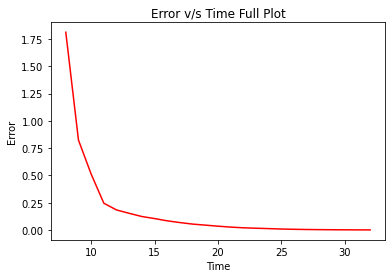

In [25]:
states = initialize_utilities(graph)
# optimal_states = converge_utilities(states, learnable, graph, 1, 0.001)
optimal_states = update_utilities(states,0.9)
temp_states=copy.deepcopy(states)

### *Simulate the game for Agent U to calculate the success rate*

In [85]:
#Agent  U
Enable_Visulization = False
states = copy.deepcopy(optimal_states)
wins = 0
simulations = 3000
for i in range(simulations):
  current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()
  # current_agent_pos , current_prey_pos , current_pred_pos = [6,1,4]
  status, vals = agent_U(states,current_agent_pos ,current_prey_pos ,current_pred_pos)
  if status == "agent wins!":
    wins = wins + 1
  # if status == "agent loses!":
  #   print( current_agent_pos , current_prey_pos , current_pred_pos)
  #   break
print("Success:",(wins/simulations) * 100) 
states =  copy.deepcopy(temp_states)

Success: 95.6


### *Visulization for a finite max value*

In [145]:
visulization_max_finite_utility(states)

Max finite Utility is 24.707059472803127 and the state is (8, 13, 12)
Let's simulate the game
Initialization: Agent Position = 8 , Prey Position = 13 , Predator Position = 12
Round 0 => Current Agent, Prey and Pred positions are: 8 , 13 , 12
Anget's turn to move:
Avilable agent moves with respective utilities: {9: inf, 7: 4, 4: 4, 8: 3}
Agent moves to : 8 , Prey moves to : 32 , Predator moves to : 9
Round 1 => Current Agent, Prey and Pred positions are: 8 , 32 , 9
Anget's turn to move:
Avilable agent moves with respective utilities: {9: inf, 7: 14, 4: 14, 8: inf}
Agent moves to : 4 , Prey moves to : 33 , Predator moves to : 8
Round 2 => Current Agent, Prey and Pred positions are: 4 , 33 , 8
Anget's turn to move:
Avilable agent moves with respective utilities: {5: 12, 3: 12, 8: inf, 4: inf}
Agent moves to : 3 , Prey moves to : 27 , Predator moves to : 4
Round 3 => Current Agent, Prey and Pred positions are: 3 , 27 , 4
Anget's turn to move:
Avilable agent moves with respective utilities:

### *Simulate game for U partial Agent to calculate success rate*

In [67]:
#Agent U Partial
states = copy.deepcopy(optimal_states)
wins = 0
ENABLE_WRITE = True
# open the file in the write mode
f = open('csv_file', 'w')
# create the csv writer
writer = csv.writer(f)
simulations = 10
for i in range(simulations):
  
  current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()
  status, vals = agent_U_partial(current_agent_pos , current_prey_pos , current_pred_pos , states,writer)
  if status == "agent wins!":
    wins = wins + 1
print("Success:",(wins/simulations) * 100) 
# close the file
f.close()
states =  copy.deepcopy(temp_states)

Success: 100.0


### *Compare Agent 1 and Agent 2from Project 2 with Agent U*

In [63]:
compare_agent1_agentU(optimal_states)

Success Rate for Agent 1: 85.86    and     Success Rate for Agent U: 99.13    and     Success Rate for Agent 2: 97.38


Avg Steps for Agent 1: 14.80    and     Avg Steps for Agent U: 10.99    and     Avg Steps for Agent 2: 15.56




### *Compare Agent 3 and Agent 4  from Project 2 with Agent U Partial*

In [104]:
compare_agent3_agent4_agentUPartial(optimal_states)


Success Rate for Agent 3: 83.42    and     Success Rate for Agent U Partial: 98.27    and     Success Rate for Agent 4: 96.38


Avg Steps for Agent 3: 15.53    and     Avg Steps for Agent U Partial: 11.79    and     Avg Steps for Agent 4: 16.92




# Model V

## Neural Network for Model V

In [27]:
import numpy as np

class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward_propogate(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward_propogate(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward_propogate(self, input):
        self.input = input
        return self.activation(input)
    
    def backward_propogate(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

# defining activation functions
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')


# defining Error metrics to use for loss calculation
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

## Data creation for model V

In [30]:
#(agent,prey,pred)
# transition probability functions
def tp_agent(old,new,graph):
  if old==new:
    return 1
  if new in graph[old]:
    return 1
  return 0

def tp_prey(old,new,graph):
  if old==new or new in graph[old]:
    return 1/(len(graph[old])+1)
  return 0

def tp_pred(old,new,agent_pos,graph):
  #if old==new or new in graph[old]:
  if new in graph[old]:
    term1 = 1/(len(graph[old]))
    dist = []
    neighbours = []
    closest_neighbours = []
    for neighbor in graph[old]:
      dist_l, path = calculate_shortest_distance( neighbor,agent_pos)
      neighbours.append(neighbor)
      dist.append(dist_l)
    min_dist = min(dist)
    for i in range(len(dist)):
      if dist[i]==min_dist:
        closest_neighbours.append(neighbours[i])
    if new in closest_neighbours:
      term2 = 1/(len(closest_neighbours))
    else:
      term2 = 0

    return 0.4*term1 + 0.6*term2
  
  return 0

# precomputing agent probs
agent_probs = {}
for i in range(1,51):
  for j in range(1,51):
    agent_probs[(i,j)] = tp_agent(i,j,graph)

# precomputing prey probs
prey_probs = {}
for i in range(1,51):
  for j in range(1,51):
    prey_probs[(i,j)] = tp_prey(i,j,graph)


# precomputing pred probs (agent, pred_old, pred_new ), tp_pred(old,new,agent_pos,graph):
pred_probs = {}
for old in range(1,51):
  for new in range(1,51):
    for agent_pos in range(1,51):
      pred_probs[(old,new,agent_pos)] = tp_pred(old,new,agent_pos,graph)



In [42]:
# def fun_data_for_V():
  # agent pos, prey pos, pred pos
agent_pos = []
prey_pos = []
pred_pos = []
degree_pred = []
degree_agent = []
distance_agent_pred = []
distance_agent_prey = []
utility = []
tp_pred_agent = []
tp_prey_agent = []

for i in optimal_states:
  if states[i] != math.inf:
    agent_pos.append(i[0])
    degree_agent.append(len(graph[i[0]])) 
    prey_pos.append(i[1]) 
    pred_pos.append(i[2])
    degree_pred.append(len(graph[i[2]]))
    utility.append(optimal_states[i])
    x,y = calculate_shortest_distance(i[0], i[2])
    distance_agent_pred.append(x)
    x,y = calculate_shortest_distance(i[0], i[1])
    distance_agent_prey.append(x)
    tp_pred_agent.append(pred_probs[(i[2],i[0],i[0])])
    tp_prey_agent.append(prey_probs[(i[1],i[0])])
  




# create graph as input
graph_dict = {}
for i in range(1,51):
  for j in range(1,51):
    if j in graph[i]:
      graph_dict[(i,j)] = [1]* (len(utility))
    else:
      graph_dict[(i,j)] = [0]* (len(utility))

# input adjacency matrix
ip1 = pd.DataFrame(graph_dict)

# input features
ip2 = pd.DataFrame(
    {'agent_pos': agent_pos,
    'prey_pos': prey_pos,
    'pred_pos': pred_pos,
    'degree_agent': degree_agent,
    'degree_pred': degree_pred,
    'distance_agent_pred' : distance_agent_pred,
    'tp_pred_agent' : tp_pred_agent,
    'tp_prey_agent' : tp_prey_agent

    })

# utility scores
op = pd.DataFrame(
    {'utility': utility
    })
x = ip2.join(ip1)

# #x.shape
# print("(115540, 2508)")
# # create the train dataset
# x_train = x.values
# y_train = op.values

# x_train = x_train.reshape(x_train.shape[0],1,2508)
# y_train = y_train.reshape(y_train.shape[0],1,1)
# # return x_train,y_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9130: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [35]:
x.to_csv("temp.csv")

In [43]:
# create the train dataset
x_train = x.values
y_train = op.values
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],1,2508)
y_train = y_train.reshape(y_train.shape[0],1,1)

x_train

(50, 2508)


array([[[ 1.,  1.,  2., ...,  1.,  1.,  0.]],

       [[ 1.,  1.,  3., ...,  1.,  1.,  0.]],

       [[ 1.,  1.,  4., ...,  1.,  1.,  0.]],

       ...,

       [[ 1.,  1., 49., ...,  1.,  1.,  0.]],

       [[ 1.,  1., 50., ...,  1.,  1.,  0.]],

       [[ 1.,  2.,  2., ...,  1.,  1.,  0.]]])

In [44]:
x_train.shape

(50, 1, 2508)

## Training the V model

In [49]:


# defining the network
network = [
    FullyConnectedLayer(2508,100),
    ActivationLayer(relu, relu_prime),
    FullyConnectedLayer(100,50),
    ActivationLayer(relu, relu_prime),
    FullyConnectedLayer(50, 1)
]


# defining parameters 
epochs = 3000
learning_rate = 0.001

# model error values
error_list = []
epoch_list = []

# model training
for epoch in range(epochs):
  error = 0
  for x, y_true in zip(x_train, y_train):
      
    # performing forward propagation
    output = x
    for layer in network:
      output = layer.forward_propogate(output)
    
    # calculating the error
    error += mse(y_true, output)

    # performing backward propagation
    output_error = mse_prime(y_true, output)
    for layer in reversed(network):
      output_error = layer.backward_propogate(output_error, learning_rate)
  
  error /= len(x_train)
  print("epoch:", epoch+1)
  print("error:",error)
  error_list.append(error)
  epoch_list.append(epoch + 1)


Streaming output truncated to the last 5000 lines.
epoch: 501
error: 0.00895367122147765
epoch: 502
error: 0.00893213133958004
epoch: 503
error: 0.008923002533639994
epoch: 504
error: 0.008835867313198364
epoch: 505
error: 0.008884030249228292
epoch: 506
error: 0.008797877991953312
epoch: 507
error: 0.008857890052067602
epoch: 508
error: 0.00885814657198589
epoch: 509
error: 0.008837778149168599
epoch: 510
error: 0.008837250578969709
epoch: 511
error: 0.00884224121233329
epoch: 512
error: 0.008818932561770404
epoch: 513
error: 0.008816735296240257
epoch: 514
error: 0.008802925271038676
epoch: 515
error: 0.008795128231268183
epoch: 516
error: 0.008781661220963546
epoch: 517
error: 0.008773134149435188
epoch: 518
error: 0.008758965633981873
epoch: 519
error: 0.008748768815872186
epoch: 520
error: 0.008738012562234148
epoch: 521
error: 0.008726551761929262
epoch: 522
error: 0.008705719115966876
epoch: 523
error: 0.008701861799944416
epoch: 524
error: 0.008692013295909356
epoch: 525
error:

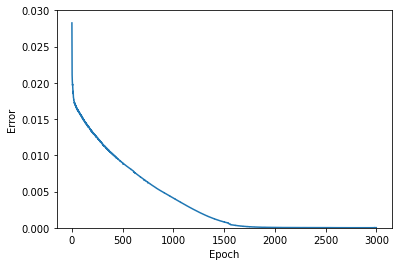

In [58]:
plt.plot(epoch_list,error_list)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.ylim([0,0.03])
plt.show()


In [66]:
y_train.shape

(0, 1, 1)

In [59]:
# predict using model V
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

# compute error
def mse_scratch(actual, predicted):
  actual = np.array(actual)
  predicted = np.array(predicted)
  differences = np.subtract(actual, predicted)
  squared_differences = np.square(differences)
  return squared_differences.mean()

## Agent V

In [62]:

# predict the utility values using model V
temp = [predict(network, x) for x in x_train]
predicted_utility_values = {}

t = 0
for state in states:
  if states[state] != math.inf:
    predicted_utility_values[state] = temp[t]
  t += 1

# y_pred = temp.copy
# print("difference between true and predicted value MSE:{}".format(mse_scratch(utility, y_pred)))

# add the utility vals which were inf back to the utilities
# use these predicted utilities to simulate the agents movements
for state in states:
  if states[state] == math.inf:
    predicted_utility_values[state]=math.inf



#Running Agent V using the predictions from model V
states = copy.deepcopy(predicted_utility_values)
wins = 0
simulations = 3000
for i in range(simulations):
  current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()
  status, vals = agent_U(states,current_agent_pos ,current_prey_pos ,current_pred_pos)
  if status == "agent wins!":
    wins = wins + 1
print("Success:",(wins/simulations) * 100) 
states =  copy.deepcopy(temp_states)




    

Success: 98.03333333333333


# Model V partial

## Neural Network for Model V partial

In [ ]:
import numpy as np

class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward_propogate(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward_propogate(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward_propogate(self, input):
        self.input = input
        return self.activation(input)
    
    def backward_propogate(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

# defining activation functions
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')


# defining Error metrics to use for loss calculation
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

## Data creation for model V partial

In [76]:
# get data from csv generated that stored the data from the simulations of U-partial
dataset = pd.read_csv("/content/temp.csv")
dataset.columns = dataset.iloc[0]
#dataset = dataset[1:]

# split data into train and test: 80-20
idxes = np.arange(0, len(dataset))
np.random.shuffle(idxes)
train_idx = int(0.8 * len(dataset))
train_data = dataset[idxes[:train_idx]]
test_data = dataset[idxes[train_idx:]]
x_train = train_data.loc[ : ,train_data.columns != 'utility']
y_train = train_data.iloc[:, -1]
x_test = test_data.loc[ : ,train_data.columns != 'utility']
y_test = test_data.iloc[:, -1]



x_train = x_train.reshape(x_train.shape[0],1,2558)
y_train = y_train.reshape(y_train.shape[0],1,1)






## Training the V model

In [94]:


# defining the network
network = [
    FullyConnectedLayer(2508,100),
    ActivationLayer(relu, relu_prime),
    FullyConnectedLayer(100,50),
    ActivationLayer(relu, relu_prime),
    FullyConnectedLayer(50, 1)
]


# defining parameters 
epochs = 3000
learning_rate = 0.01

# model error values
error_list = []
epoch_list = []

# model training
for epoch in range(epochs):
  error = 0
  for x, y_true in zip(x_train, y_train):
      
    # performing forward propagation
    output = x
    for layer in network:
      output = layer.forward_propogate(output)
    
    # calculating the error
    error += mse(y_true, output)

    # performing backward propagation
    output_error = mse_prime(y_true, output)
    for layer in reversed(network):
      output_error = layer.backward_propogate(output_error, learning_rate)
  
  error /= len(x_train)
  print("epoch:", epoch+1)
  print("error:",error)
  error_list.append(error)
  epoch_list.append(epoch + 1)



epoch: 1
error: 0.0692418934547624
epoch: 2
error: 0.01742609396711081
epoch: 3
error: 0.02571536114095955
epoch: 4
error: 0.020434090007481694
epoch: 5
error: 0.019690965049268518
epoch: 6
error: 0.019425258041422838
epoch: 7
error: 0.01905287692262431
epoch: 8
error: 0.018761845521048516
epoch: 9
error: 0.018798304083033263
epoch: 10
error: 0.01843149054169953
epoch: 11
error: 0.018125210913882746
epoch: 12
error: 0.018468454507411934
epoch: 13
error: 0.018348601766586578
epoch: 14
error: 0.018123354735987945
epoch: 15
error: 0.017782724294279007
epoch: 16
error: 0.01767253018462221
epoch: 17
error: 0.017952121201139874
epoch: 18
error: 0.017346096328771456
epoch: 19
error: 0.01783047891292633
epoch: 20
error: 0.017292349566378068
epoch: 21
error: 0.01737013558396115
epoch: 22
error: 0.017498467231724043
epoch: 23
error: 0.01706036102704664
epoch: 24
error: 0.01702542905094927
epoch: 25
error: 0.016806131992186973
epoch: 26
error: 0.016994710150673227
epoch: 27
error: 0.0166856231309

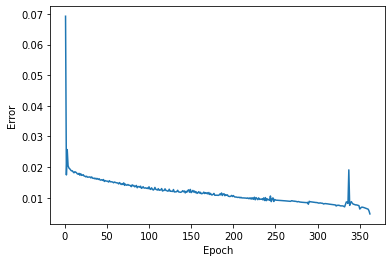

In [95]:
plt.plot(epoch_list,error_list)
plt.xlabel("Epoch")
plt.ylabel("Error")
# plt.ylim([0,0.03])
plt.show()


In [ ]:
y_train.shape

(0, 1, 1)

In [ ]:
# predict using model V_partial
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

# compute error
def mse_scratch(actual, predicted):
  actual = np.array(actual)
  predicted = np.array(predicted)
  differences = np.subtract(actual, predicted)
  squared_differences = np.square(differences)
  return squared_differences.mean()

## Agent V Partial

In [96]:
def move_agent_V_partial(graph, current_agent_pos, prey_beliefs, current_pred_pos,store_row):
  agent_neighbours = graph[current_agent_pos] + [current_agent_pos]
  utility_vals = {}
  for neighbour in agent_neighbours:
    uv= predict(network, store_row)
    if(str(uv)!="nan"):
      utility_vals[neighbour] = uv
  min_uv = min(utility_vals.values())
  best_move = [i for i in utility_vals if utility_vals[i]==min_uv]
  if(len(best_move)<=0):
    print("hh")
  return random.choice(best_move)
  

In [97]:
def agent_V_partial(current_agent_pos , current_prey_pos , current_pred_pos , states):

  timesteps = 0
  ini_prey_pos = 0
  correctly_identified_prey_pos = 0
  # initialize prey beliefs
  beliefs = [1/49]*(len(graph)+1)
  beliefs[0] = 0
  beliefs[current_agent_pos] = 0
  pos_where_prey_not_there = []
  pos_where_prey_not_there.append(current_agent_pos)



  while (True):
    store_row = [current_agent_pos,current_pred_pos,len(graph[current_agent_pos]),len(graph[current_pred_pos]),calculate_shortest_distance(current_agent_pos,current_pred_pos)[0]]
    if (current_agent_pos == current_prey_pos and current_prey_pos == current_pred_pos):
      return ("all 3 in same node, nobody wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    elif (current_agent_pos == current_prey_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    elif (current_agent_pos == current_pred_pos):
      return ("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break

    #The three players move inrounds, starting with the Agent, followed by the Prey, followed by the Predator.
    

  
    # agent 3 surveys nodes and returns the next move of the agent
    
    # find node with max belief, cut ties at random
    max_belief = max(beliefs)

    nodes_with_max_belief = [i for i in range(1,len(beliefs)) if beliefs[i]==max_belief]
    # surveyed_node = nodes_with_max_belief[random.randint(0,len(nodes_with_max_belief)-1)]
    if(len(nodes_with_max_belief)<=0):
      print("h",max_belief)
      break
    surveyed_node = random.choice(nodes_with_max_belief)

    store_row.append(surveyed_node)

    temp_store_row = copy.deepcopy(store_row)

    store_row += beliefs

    # write a row to the csv file
    # if ENABLE_WRITE: writer.writerow(store_row)

    # store_row.pop()
    store_row = copy.deepcopy(temp_store_row)

    # survey the node
    if surveyed_node == current_prey_pos:
      state = True
      correctly_identified_prey_pos += 1
    else:
      state = False
      pos_where_prey_not_there.append(surveyed_node)  
    
    # update beliefs
    beliefs = update_belief_survey(beliefs, surveyed_node, state, graph,node_degree,pos_where_prey_not_there)
    store_row += beliefs
    # store_row.append(beliefs)

    # write a row to the csv file
    # if ENABLE_WRITE: writer.writerow(store_row)
    # store_row.pop()
    # store_row = copy.deepcopy(temp_store_row)
    
    # choose node with max probability as the prey pos and moving agent towards it
    max_belief = max(beliefs)
    nodes_with_max_belief = []
    for i in range(len(beliefs)):
      if beliefs[i]==max_belief:
        nodes_with_max_belief.append(i)
    #print(max_belief, nodes_with_max_belief)
    # t = random.randint(0,len(nodes_with_max_belief)-1)
    if(len(nodes_with_max_belief)<=0):
      print("h2",max_belief)
      break
    
    prey_pos = random.choice(nodes_with_max_belief)
    agent_next_pos = move_agent_V_partial(graph, current_agent_pos, beliefs, current_pred_pos,store_row)
    
    store_row = copy.deepcopy(temp_store_row)

    # move the agent to next pos
    current_agent_pos = agent_next_pos
    timesteps += 1

    # check if pred in agent pos
    if current_agent_pos == current_pred_pos: # pred kills agent
      return("agent loses!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    # if (timesteps > t_hangs):
    #   return("agent timesteps!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])


    # update the beliefs after agent moves
    if current_agent_pos == current_prey_pos: # prey found
      return("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    else: # prey not found
      state = False
      pos_where_prey_not_there.append(current_agent_pos)
      beliefs = update_belief_survey(beliefs, current_agent_pos, state, graph,node_degree,pos_where_prey_not_there)
      # store_row.append(beliefs)
      store_row += beliefs

      # write a row to the csv file
      # if ENABLE_WRITE: writer.writerow(store_row)
      # store_row.pop()
      store_row = copy.deepcopy(temp_store_row)

    #current_agent_pos, beliefs, state_p, surveyed_node = move_agent3(graph, current_agent_pos, current_prey_pos,beliefs,node_degree)

    #print("update the beliefs after agent moves",sum(beliefs))
    #print(beliefs)
    

    if(ini_prey_pos  < len(prey_pos_list)):
      current_prey_pos = prey_pos_list[ini_prey_pos]
      ini_prey_pos += 1
    else:
      current_prey_pos = move_prey(graph, current_prey_pos)
    prey_pos_list.append(current_prey_pos) 
    pos_where_prey_not_there = []

    # current_prey_pos = move_prey(graph, current_prey_pos)


    # update beliefs after prey moves
    if (current_prey_pos==current_agent_pos):
      return ("agent wins!",[current_agent_pos, current_prey_pos, current_pred_pos,(correctly_identified_prey_pos/timesteps)*100])
      break
    else:
      beliefs = update_belief_move(beliefs, graph, node_degree)

    #print("update beliefs after prey moves:",sum(beliefs))
    #print(beliefs)

    # predator moves
    current_pred_pos = move_distracted_predator(graph, current_pred_pos, current_agent_pos)





In [105]:

# predict the utility values using model V
temp = [predict(network, x) for x in x_train]
predicted_utility_values = {}

t = 0
for state in states:
  if states[state] != math.inf:
    predicted_utility_values[state] = temp[t]
  t += 1

# y_pred = temp.copy
# print("difference between true and predicted value MSE:{}".format(mse_scratch(utility, y_pred)))

# add the utility vals which were inf back to the utilities
# use these predicted utilities to simulate the agents movements
for state in states:
  if states[state] == math.inf:
    predicted_utility_values[state]=math.inf



#Running Agent V using the predictions from model V
states = copy.deepcopy(predicted_utility_values)
wins = 0
simulations = 3000
for i in range(simulations):
  current_agent_pos , current_prey_pos , current_pred_pos = initilise_prey_pred_agent()
  status, vals = agent_V_partial(states,current_agent_pos ,current_prey_pos ,current_pred_pos)
  if status == "agent wins!":
    wins = wins + 1
print("Success:",(wins/simulations) * 100) 
states =  copy.deepcopy(temp_states)




  

Success: 91.67
